In [1]:
from ultralytics import YOLO
from roboflow import Roboflow
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
from PIL import Image
import cv2
from matplotlib.patches import Patch
from pathlib import Path
import random

In [ ]:
rf = Roboflow(api_key="YsxfUCB8l2EZX1mXAv7v")
project = rf.workspace("recherdataplace").project("contrails-0lwhn")
version = project.version(2)
dataset = version.download("yolov8-obb")

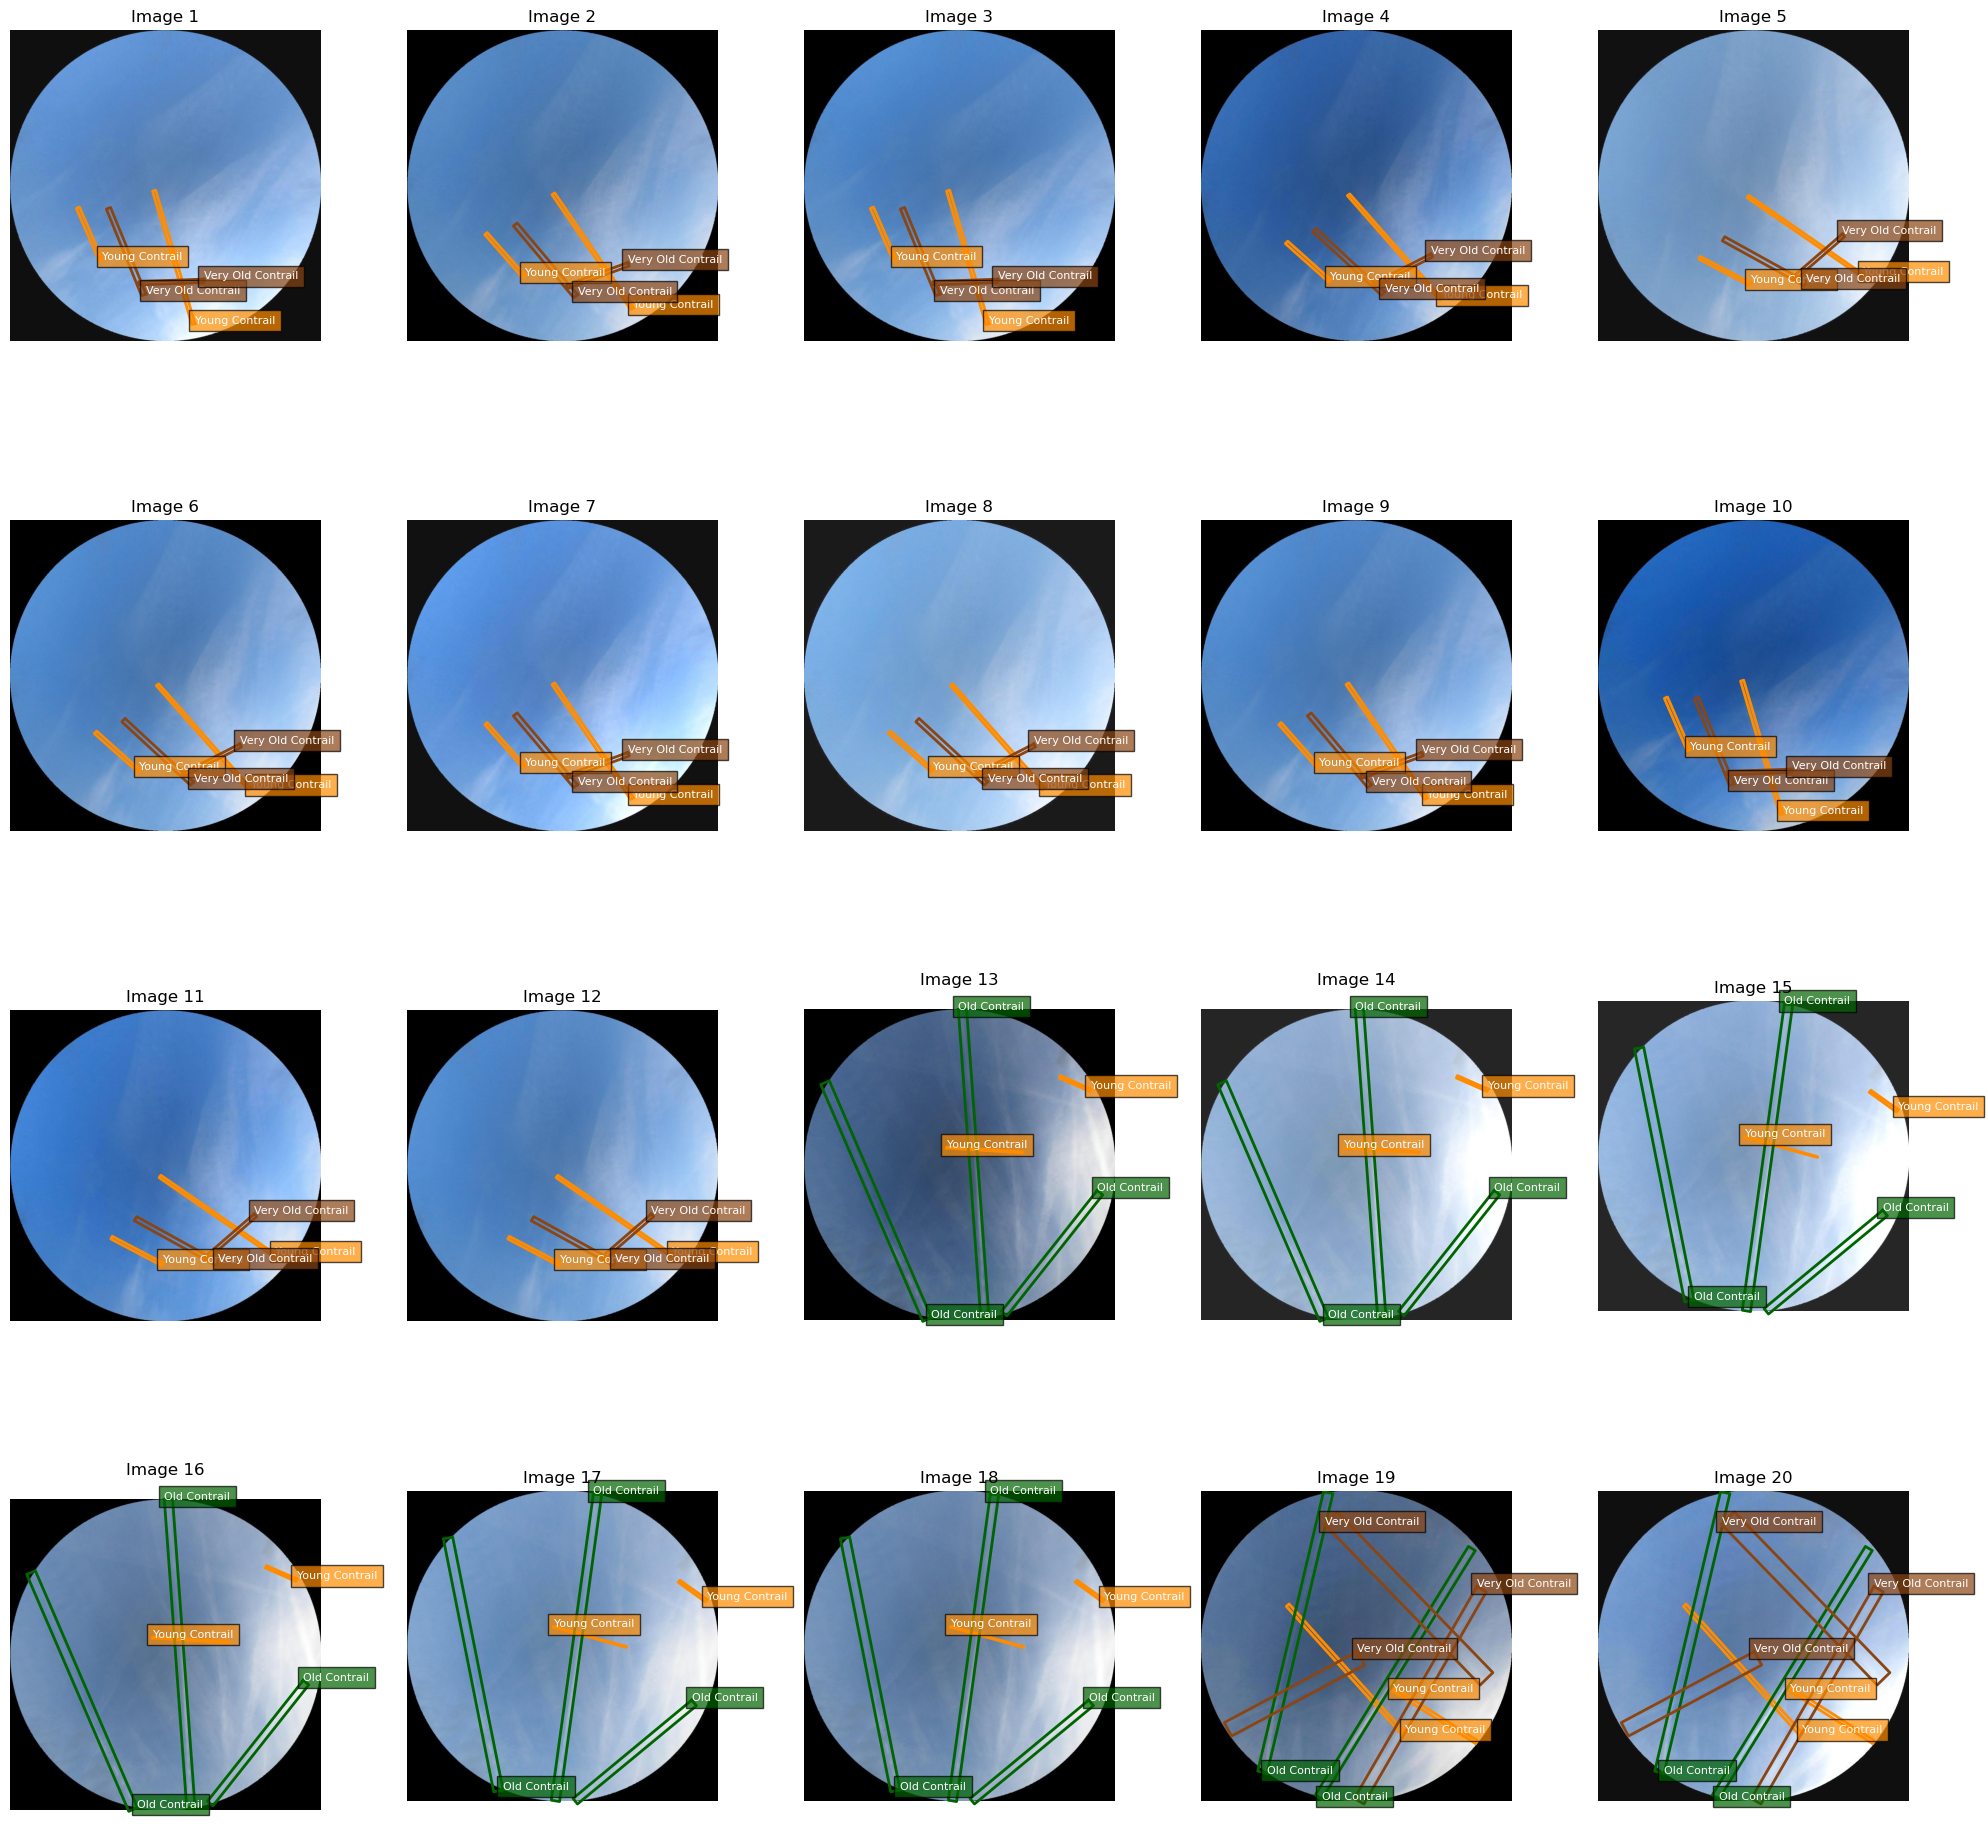

Tổng số class trong toàn bộ dataset: 6

Danh sách các class:
Class 0: Old Contrail
Class 1: Very Old Contrail
Class 2: Young Contrail
Class 3: Parasite
Class 4: Sun
Class 5: Unknown


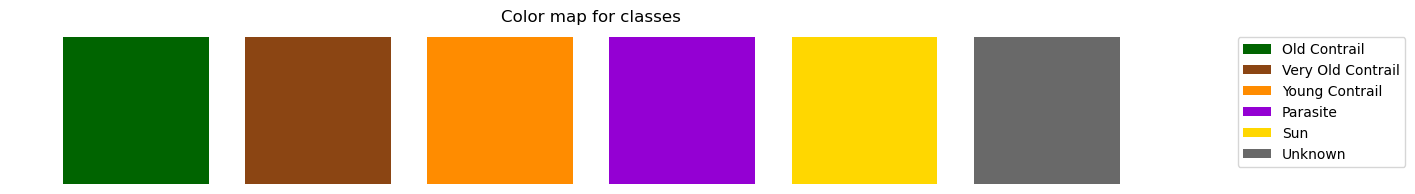

In [2]:
# Đường dẫn đến thư mục chứa ảnh và label
image_dir = 'contrails-2/train/images/'
label_dir = 'contrails-2/train/labels'

# Dictionary chứa tên các class
class_names = {
    0: 'Old Contrail',
    1: 'Very Old Contrail',
    2: 'Young Contrail',
    3: 'Parasite',
    4: 'Sun',
    5: 'Unknown'
}

# Đếm số class trong toàn bộ dataset
def count_unique_classes(label_dir):
    unique_classes = set()
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    
    for label_path in label_files:
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.strip().split()
                    if len(values) >= 9:
                        class_id = int(values[0])
                        unique_classes.add(class_id)
    
    return unique_classes

# Tạo color map dựa trên các class
unique_classes = count_unique_classes(label_dir)
color_map = {
    0: (0 / 255, 100 / 255, 0 / 255),       # Old Contrail: Dark Green
    1: (139 / 255, 69 / 255, 19 / 255),    # Very Old Contrail: Saddle Brown
    2: (255 / 255, 140 / 255, 0 / 255),    # Young Contrail: Dark Orange
    3: (148 / 255, 0 / 255, 211 / 255),    # Parasite: Dark Violet
    4: (255 / 255, 215 / 255, 0 / 255),    # Sun: Gold
    5: (105 / 255, 105 / 255, 105 / 255)   # Unknown: Dim Gray
}


# Lấy danh sách các file ảnh
image_files = glob.glob(os.path.join(image_dir, '*.jpg'))

# Hàm đọc file label
def read_label_file(label_path):
    if not os.path.exists(label_path):
        return []
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        values = line.strip().split()
        if len(values) >= 9:
            class_id = int(values[0])
            points = np.array([[float(values[i]), float(values[i+1])] for i in range(1, len(values), 2)])
            boxes.append((class_id, points))
    return boxes

# Hiển thị 20 ảnh đầu tiên có label
count = 0
plt.figure(figsize=(20, 20))

for img_path in image_files:
    if count >= 20:
        break
        
    # Đọc ảnh
    img = np.array(Image.open(img_path))
    if img is None:
        continue
        
    # Lấy tên file label tương ứng
    base_name = os.path.basename(img_path)
    label_path = os.path.join(label_dir, base_name.replace('.jpg', '.txt'))
    
    # Đọc label
    boxes = read_label_file(label_path)
    if not boxes:
        continue
        
    # Tạo subplot
    plt.subplot(4, 5, count + 1)
    plt.imshow(img)
    
    # Vẽ các box
    height, width = img.shape[:2]
    for class_id, points in boxes:
        # Chuyển đổi tọa độ từ relative sang absolute
        points = points * np.array([width, height])
        points = points.astype(np.int32)
        
        # Thêm điểm đầu vào cuối để tạo polygon khép kín
        points_closed = np.vstack((points, points[0]))
        
        # Vẽ polygon với màu tương ứng với class
        color = color_map[class_id]
        plt.plot(points_closed[:, 0], points_closed[:, 1], '-', color=color, linewidth=2)
        
        # Hiển thị class_id và tên
        plt.text(points[0, 0], points[0, 1], f'{class_names[class_id]}', 
                color='white', fontsize=8, 
                bbox=dict(facecolor=color, alpha=0.7))
    
    plt.title(f'Image {count+1}')
    plt.axis('off')
    count += 1

plt.tight_layout()
plt.show()

print(f"Tổng số class trong toàn bộ dataset: {len(unique_classes)}")
print("\nDanh sách các class:")
for class_id in sorted(list(unique_classes)):
    print(f"Class {class_id}: {class_names[class_id]}")

# Hiển thị color map
plt.figure(figsize=(15, 2))
for i, (class_id, color) in enumerate(color_map.items()):
    plt.bar(i, 1, color=color, label=f'{class_names[class_id]}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Color map for classes')
plt.axis('off')
plt.show()

In [4]:
# Đường dẫn tới file trọng số đã lưu
weights_path = 'models/weights.pt'

if os.path.exists(weights_path):
    print("Model đã được huấn luyện. Đang tải trọng số...")
    model = YOLO(weights_path)  # Tải model từ file trọng số
else:
    print("Model chưa được huấn luyện. Bắt đầu huấn luyện...")
    # Cấu hình model mới
    model = YOLO('models/yolov8n-obb.pt')  # Chọn YOLOv8 base hoặc các phiên bản khác (yolov8n, yolov8s, ...)
    
    # Huấn luyện model
    results = model.train(
        data='contrails-2/data.yaml',  # Sử dụng file YAML
        epochs=100,
        imgsz=640,
        batch=16,
        device=0,
        workers=8,
        patience=50,
        save=True,
        project='runs/detect',
        name='contrails_train'
    )
    
    # Lưu model đã huấn luyện
    model.save(weights_path)
    print(f"Trọng số đã được lưu tại: {weights_path}")

Model đã được huấn luyện. Đang tải trọng số...



image 1/1 c:\Users\Bi Minh Thi\OneDrive - INSA Toulouse\5A\S1\Projet RI\Contrail Detection\contrails-2\test\images\20190501_071800_01_png_jpg.rf.9e71b2b62841d4a7b7cf24b5efbf2266.jpg: 640x640 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Bi Minh Thi\OneDrive - INSA Toulouse\5A\S1\Projet RI\Contrail Detection\contrails-2\test\images\20190703_073200_01_png_jpg.rf.b023ce44268fda278d394c5a4ca72f9e.jpg: 640x640 58.0ms
Speed: 4.0ms preprocess, 58.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Bi Minh Thi\OneDrive - INSA Toulouse\5A\S1\Projet RI\Contrail Detection\contrails-2\test\images\20190501_183000_01_png_jpg.rf.67afd50d0994ed97004268187a105ecc.jpg: 640x640 59.0ms
Speed: 4.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\Bi Minh Thi\OneDrive - INSA Toulouse\5A\S1\Projet RI\Contrail Detection\contrails-2\test\ima

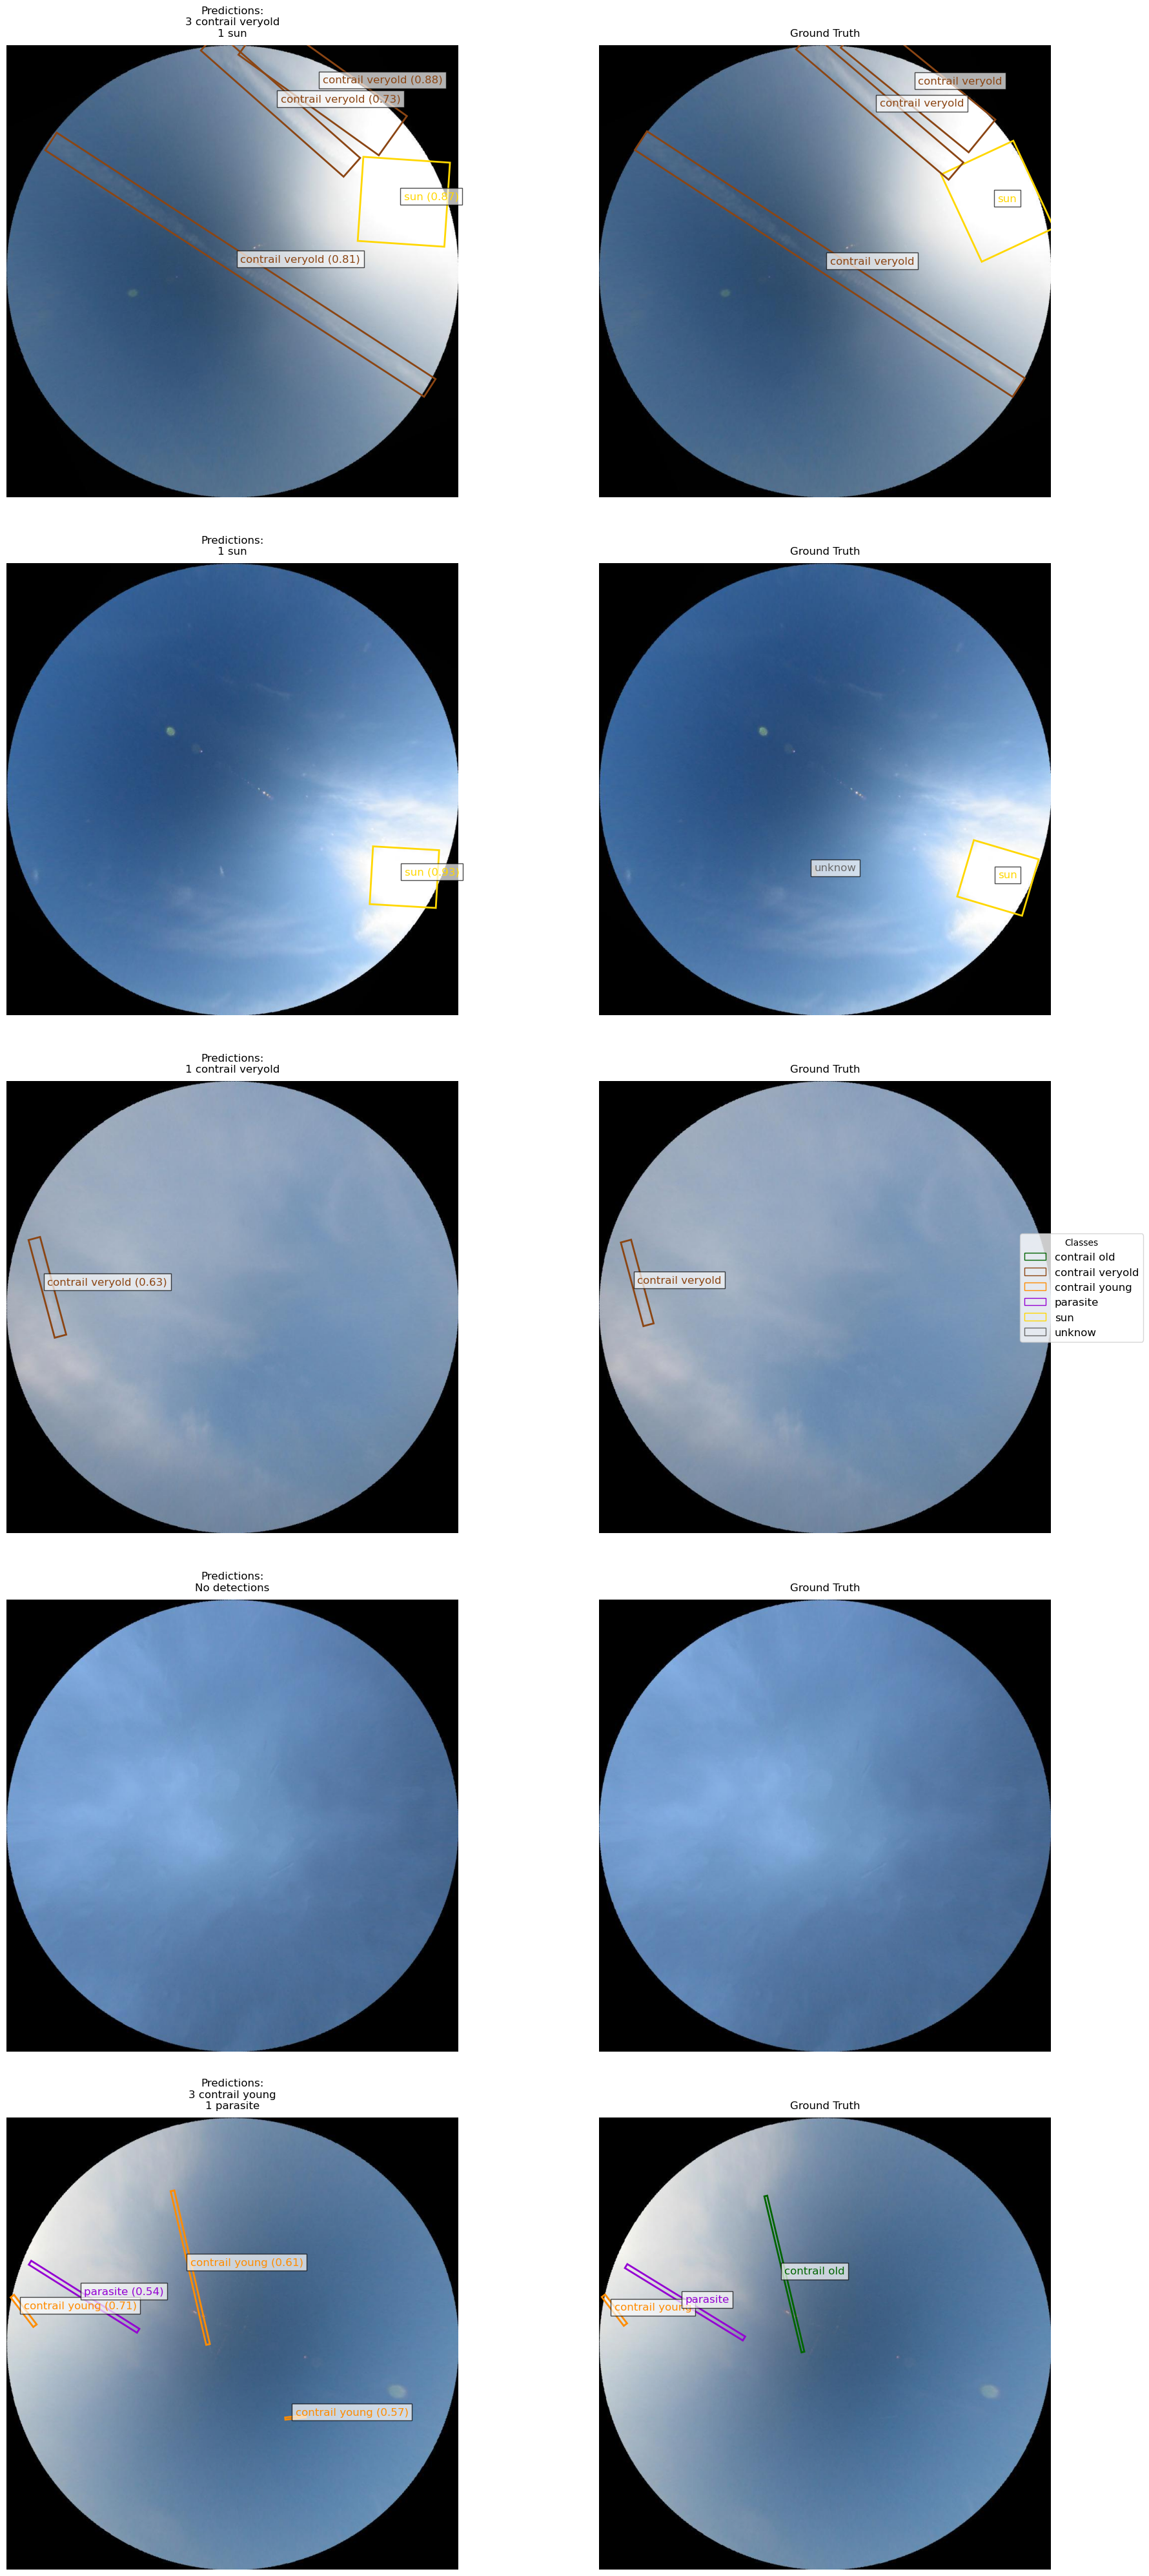

In [7]:
def plot_predictions_and_truth(model, test_path, num_images=5):
    test_images = list(Path(test_path).glob('*.jpg'))
    selected_images = random.sample(test_images, num_images)
    
    fig, axes = plt.subplots(5, 2, figsize=(20, 40))
    
    for idx, img_path in enumerate(selected_images):
        # Đọc ảnh
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Hiển thị ảnh
        axes[idx, 0].imshow(img)
        axes[idx, 1].imshow(img)
        
        # Lấy predictions
        results = model.predict(str(img_path))
        result = results[0]
        class_names = result.names
        
        # Vẽ predicted boxes (bên trái)
        detection_counts = {}
        
        if result.obb is not None:
            obb = result.obb
            for i in range(len(obb)):
                class_id = int(obb.cls[i])
                conf = float(obb.conf[i])
                
                # Lấy tọa độ 8 điểm từ xyxyxyxy
                points = obb.xyxyxyxy[i].cpu().numpy().reshape(-1, 2)
                
                color = color_map[class_id]
                polygon = plt.Polygon(points, fill=False, color=color, linewidth=2)
                axes[idx, 0].add_patch(polygon)
                
                # Label với confidence
                center = points.mean(axis=0)
                axes[idx, 0].text(center[0], center[1] - 5, 
                                f'{class_names[class_id]} ({conf:.2f})',
                                color=color, fontsize=12,
                                bbox=dict(facecolor='white', alpha=0.7))
                
                # Đếm số lượng detections
                class_name = class_names[class_id]
                detection_counts[class_name] = detection_counts.get(class_name, 0) + 1
        
        # Vẽ ground truth (bên phải)
        label_path = str(img_path).replace('images', 'labels').replace('.jpg', '.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    values = [float(x) for x in line.strip().split()]
                    class_id = int(values[0])
                    coords = np.array(values[1:]).reshape(-1, 2)
                    coords[:, 0] *= img.shape[1]
                    coords[:, 1] *= img.shape[0]
                    color = color_map[class_id]
                    polygon = plt.Polygon(coords, fill=False, color=color, linewidth=2)
                    axes[idx, 1].add_patch(polygon)
                    
                    # Thêm label cho ground truth
                    center = coords.mean(axis=0)
                    axes[idx, 1].text(center[0], center[1],
                                    class_names[class_id],
                                    color=color, fontsize=12,
                                    bbox=dict(facecolor='white', alpha=0.7))
        
        # Thêm title
        if detection_counts:
            pred_title = "Predictions:\n" + "\n".join([f"{count} {name}" for name, count in detection_counts.items()])
        else:
            pred_title = "Predictions:\nNo detections"
            
        axes[idx, 0].set_title(pred_title, fontsize=12, pad=10)
        axes[idx, 1].set_title('Ground Truth', fontsize=12, pad=10)
        
        # Tắt axis
        axes[idx, 0].axis('off')
        axes[idx, 1].axis('off')
    
    plt.tight_layout(h_pad=3.0, w_pad=1.0)
    
    # Thêm chú thích chung
    legend_elements = [
        Patch(facecolor='none', edgecolor=color, label=name)
        for i, (color, name) in enumerate(zip(color_map.values(), class_names.values()))
    ]
    
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5), 
              fontsize=12, title='Classes')
    plt.show()

# Test model với tập test
test_path = 'contrails-2/test/images'
plot_predictions_and_truth(model, test_path)